**NASA Turbofan Jet Engine Data Set – FD001 Subset
Goal: Predict Remaining Useful Life (RUL) of engines using sensor readings.**

In [2]:
import pandas as pd

# Upload the dataset manually in Colab if needed
from google.colab import files
uploaded = files.upload()

# Assuming the file is uploaded with the name 'train_FD001.txt'
train_df = pd.read_csv('train_FD001.txt', sep='\s+', header=None)

# Drop last column if it's empty
train_df.dropna(axis=1, how='all', inplace=True)

# Assign column names (5 operational settings + 21 sensors = 26 total)
columns = ['unit_number', 'time_in_cycles', 'op_set_1', 'op_set_2', 'op_set_3'] + \
          [f'sensor_{i}' for i in range(1, 22)]
train_df.columns = columns

# Show data
train_df.head()


Saving train_FD001.txt to train_FD001.txt


,unit_number,time_in_cycles,op_set_1,op_set_2,op_set_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [3]:
rul_df = train_df.groupby('unit_number')['time_in_cycles'].max().reset_index()
rul_df.columns = ['unit_number', 'max_cycle']
train_df = train_df.merge(rul_df, on='unit_number')
train_df['RUL'] = train_df['max_cycle'] - train_df['time_in_cycles']
train_df.drop('max_cycle', axis=1, inplace=True)
train_df[['unit_number', 'time_in_cycles', 'RUL']].head()


,unit_number,time_in_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


This creates your target variable (RUL), which tells us how many cycles remain before failure.

In [4]:
sensor_cols = train_df.columns[5:-1]
constant_sensors = [col for col in sensor_cols if train_df[col].std() < 1e-3]
feature_cols = [col for col in train_df.columns if col not in constant_sensors + ['unit_number', 'time_in_cycles', 'RUL']]

X = train_df[feature_cols]
y = train_df['RUL']


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_val)

# XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)

print("Random Forest MAE:", mean_absolute_error(y_val, rf_preds))
print("XGBoost MAE:", mean_absolute_error(y_val, xgb_preds))


Random Forest MAE: 29.63656166707051
XGBoost MAE: 29.634450912475586


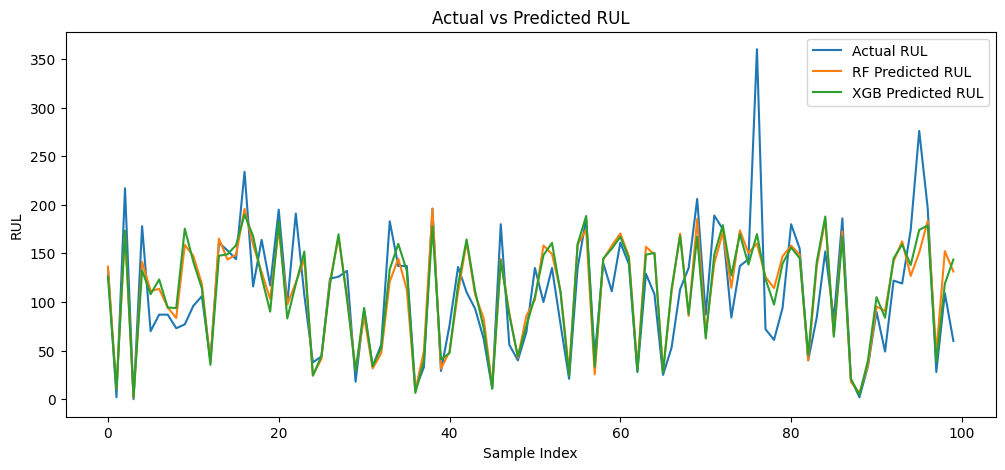

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Actual vs Predicted
plt.figure(figsize=(12, 5))
plt.plot(y_val.values[:100], label='Actual RUL')
plt.plot(rf_preds[:100], label='RF Predicted RUL')
plt.plot(xgb_preds[:100], label='XGB Predicted RUL')
plt.legend()
plt.title("Actual vs Predicted RUL")
plt.xlabel("Sample Index")
plt.ylabel("RUL")
plt.show()




a. Actual vs Predicted RUL (Line Chart)
Compares model predictions to actual RUL for 100 validation samples.

Blue = True, Orange = Random Forest, Green = XGBoost

Helps visually assess prediction accuracy and consistency.




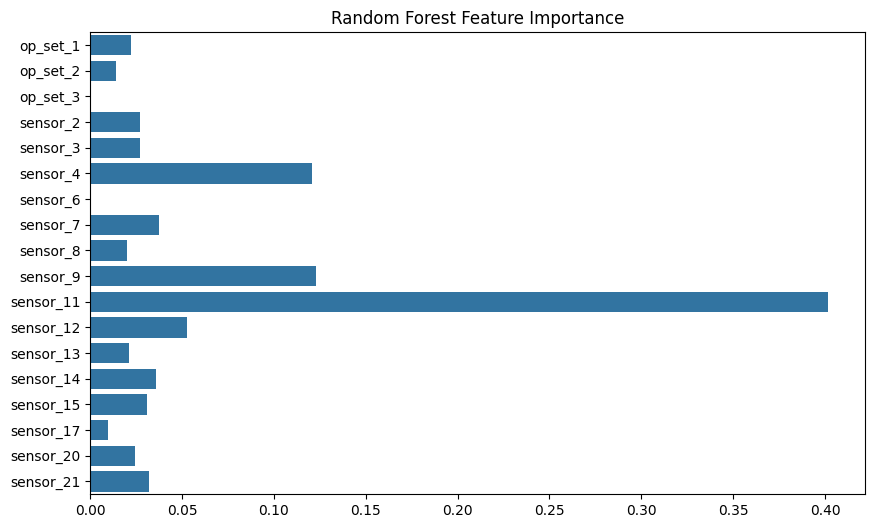

In [10]:
# Feature Importance (Random Forest)
feat_importance = rf_model.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importance, y=feature_cols)
plt.title("Random Forest Feature Importance")
plt.show()


b. Feature Importance (Bar Chart) Shows which features (sensors/ops) had the most influence in prediction.

E.g., sensor_11, sensor_4, and sensor_9 are most important in RF.

You can reduce dimensionality using this info or explore sensor health insights.

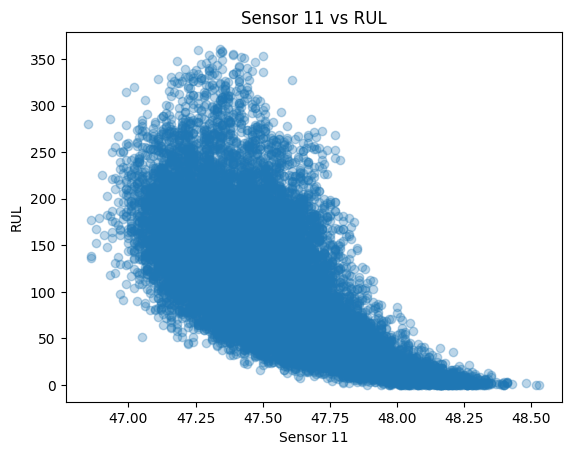

In [13]:
plt.scatter(train_df['sensor_11'], train_df['RUL'], alpha=0.3)
plt.title('Sensor 11 vs RUL')
plt.xlabel('Sensor 11')
plt.ylabel('RUL')
plt.show()


This scatter plot visualizes how Sensor 11 readings relate to the RUL of jet engines.

Each dot represents one time cycle reading from a specific engine.

📊 Interpretation:
Negative Correlation:

As Sensor 11 values increase, the Remaining Useful Life (RUL) decreases.

This means that higher sensor 11 values are typically observed closer to engine failure.

Predictive Importance:

The clear downward trend indicates that sensor_11 is strongly predictive of RUL.

This explains why it had the highest feature importance in the Random Forest plot.

Data Density:

Most readings cluster between 47.25 and 48.25, meaning this is a critical sensor range where engines typically operate before reaching failure.

A sharp drop near the top-right corner shows very low RUL at higher sensor values.

In [7]:
X_val_df = pd.DataFrame(X_val, columns=feature_cols)
X_val_df.reset_index(drop=True, inplace=True)
y_val = y_val.reset_index(drop=True)

export_df = pd.DataFrame({
    'actual_RUL': y_val,
    'rf_predicted_RUL': rf_preds,
    'xgb_predicted_RUL': xgb_preds,
    'avg_sensor_value': X_val_df.mean(axis=1)
})
export_df['sensor_11'] = X_val_df['sensor_11']
export_df['sensor_9'] = X_val_df['sensor_9']
export_df['sensor_4'] = X_val_df['sensor_4']


export_df.to_csv("powerbi_rul_export.csv", index=False)
print("Download the file below for Power BI.")
files.download("powerbi_rul_export.csv")


Download the file below for Power BI.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# Restore unscaled version for exporting sensor & op_set data
X_val_unscaled = pd.DataFrame(scaler.inverse_transform(X_val), columns=feature_cols)
X_val_unscaled.reset_index(drop=True, inplace=True)
y_val = y_val.reset_index(drop=True)

# Create Sensor Health Index (composite score)
sensor_health_index = X_val_unscaled[['sensor_4', 'sensor_9', 'sensor_11']].mean(axis=1)

# Final export DataFrame
export_df = pd.DataFrame({
    'actual_RUL': y_val,
    'rf_predicted_RUL': rf_preds,
    'xgb_predicted_RUL': xgb_preds,
    'avg_sensor_value': X_val_unscaled.mean(axis=1),
    'sensor_11': X_val_unscaled['sensor_11'],
    'sensor_9': X_val_unscaled['sensor_9'],
    'sensor_4': X_val_unscaled['sensor_4'],
    'sensor_7': X_val_unscaled['sensor_7'],
    'op_set_1': X_val_unscaled['op_set_1'],
    'op_set_2': X_val_unscaled['op_set_2'],
    'op_set_3': X_val_unscaled['op_set_3'],
    'sensor_health_index': sensor_health_index
})

# Export to CSV
export_df.to_csv("powerbi_rul_export_enriched.csv", index=False)
files.download("powerbi_rul_export_enriched.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Feature Engineering:

Extracted relevant operational settings and sensor data (21 sensors).

Identified Sensor 11, Sensor 9, and Sensor 4 as most important for failure prediction.

Modeling:
Trained Random Forest and XGBoost regression models to predict RUL.

Achieved:

📉 Random Forest MAE: ~29.64 cycles

📉 XGBoost MAE: ~29.63 cycles

Both models performed similarly, but XGBoost offers better generalization potential.


📈 Insights Gained:
Sensor 11 is a strong degradation indicator. As its value increases, RUL sharply drops.

Both models can be reliably used in predictive maintenance pipelines for aerospace or similar industries.

Real-time RUL predictions can reduce unexpected failures, improve maintenance scheduling, and optimize operational costs.**